This Jupyter notebook serves as a first user guide to beta testers of EIS Toolkit. It shows how to import and call various tools of EIS Toolkit and includes steps of a simple MPM workflow.

Note that to run this notebook without modifications you need to have the test data (and under correct folder structure). One can always change the filepaths and use their own data, granted that the data is in right the format and is meaningful geospatial data. However, the primary function of this notebook is not to provide a template for conducting MPM workflows, but instead serve as example and showcase some of the tools of EIS Toolkit.

### 1. Imports and filepath definitions

In [36]:
%matplotlib inline

import os
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

from rasterio.io import MemoryFile
from rasterio.plot import show

import sys
sys.path.insert(0, "..")

from eis_toolkit.exploratory_analyses.basic_plots_seaborn import pairplot, kdeplot
from eis_toolkit.exploratory_analyses.parallel_coordinates import plot_parallel_coordinates
from eis_toolkit.exploratory_analyses.descriptive_statistics import descriptive_statistics_raster

from eis_toolkit.prediction.fuzzy_overlay import gamma_overlay
from eis_toolkit.prediction.weights_of_evidence import weights_of_evidence_calculate_weights, weights_of_evidence_calculate_responses

from eis_toolkit.raster_processing.unifying import unify_raster_grids
from eis_toolkit.raster_processing.distance_to_anomaly import distance_to_anomaly

from eis_toolkit.transformations.sigmoid import _sigmoid_transform
from eis_toolkit.transformations.linear import _min_max_scaling

from eis_toolkit.vector_processing.idw_interpolation import idw
from eis_toolkit.vector_processing.distance_computation import distance_computation

from eis_toolkit.evaluation.calculate_base_metrics import calculate_base_metrics
from eis_toolkit.evaluation.plot_rate_curve import plot_rate_curve


In [4]:
# Folder with the test data in it. Modify this match the location of your test data folder.
test_data_folder = "../tests/data/local/workflow_demo"

AEM_inphase_fp = os.path.join(test_data_folder, "IOCG_AEM_Inph_.tif")
AEM_quad_fp = os.path.join(test_data_folder, "IOCG_AEM_Quad.tif")
AEM_ratio_fp = os.path.join(test_data_folder, "IOCG_EM_ratio.tif")
Magn_AS_fp = os.path.join(test_data_folder, "IOCG_Magnetic.tif")

till_geochem_fp = os.path.join(test_data_folder, "IOCG_CLB_Till_Geochem_reg_511p.shp")
structures_fp = os.path.join(test_data_folder, "IOCG_CLB_Structures_1M.shp")
lithology_fp = os.path.join(test_data_folder, "IOCG_CLB_Lith_Asstn_1M.shp")
known_occurances_fp = os.path.join(test_data_folder, "IOCG_Deps_Prosp_Occs.shp")

In [41]:
# Additionally, we suppress warnings, because the possible warnings are not related to EIS Toolkit but Seaborn
# and other underlaying libraries. 
import warnings
warnings.filterwarnings('ignore')

## 2. Preprocess data

For preprocessing, three main tools to create proxy data for modeling are showcased: Interpolation of vector data (typically geochemical data), computing distances to vector features (typically geological data) and computing distances to anomalous pixels (typically geophysical data). Beside these, some other tools and steps to prepare data are used.

#### Selecting a base raster

As the first thing, one raster should be selected to be the base raster with desired grid properties. This raster is read and its profile saved to be used in processing tools.

In [9]:
# Select AEM_inphase raster profile as the baes raster
with rasterio.open(AEM_inphase_fp) as AEM_inphase:
    raster_profile = AEM_inphase.profile

#### Preprocess geochemical data

Interpolate selected element concentrations.

In [6]:
till_geochem = gpd.read_file(till_geochem_fp)

In [ ]:
# Iron interpolated
till_geochem["fe_log"] = np.log(till_geochem["Fe_ppm_511"])
fe_interpolated = idw(geodataframe=till_geochem, target_column="fe_log", raster_profile=raster_profile, power=2)

In [ ]:
# Lithium interpolated
till_geochem["li_log"] = np.log(till_geochem["Li_ppm_511"])
li_interpolated = idw(till_geochem, "li_log", raster_profile)

In [ ]:
# Copper interpolated
till_geochem["cu_log"] = np.log(till_geochem["Cu_ppm_511"])
cu_interpolated = idw(till_geochem, "cu_log", raster_profile)

<Axes: title={'center': 'Cu interpolated'}>

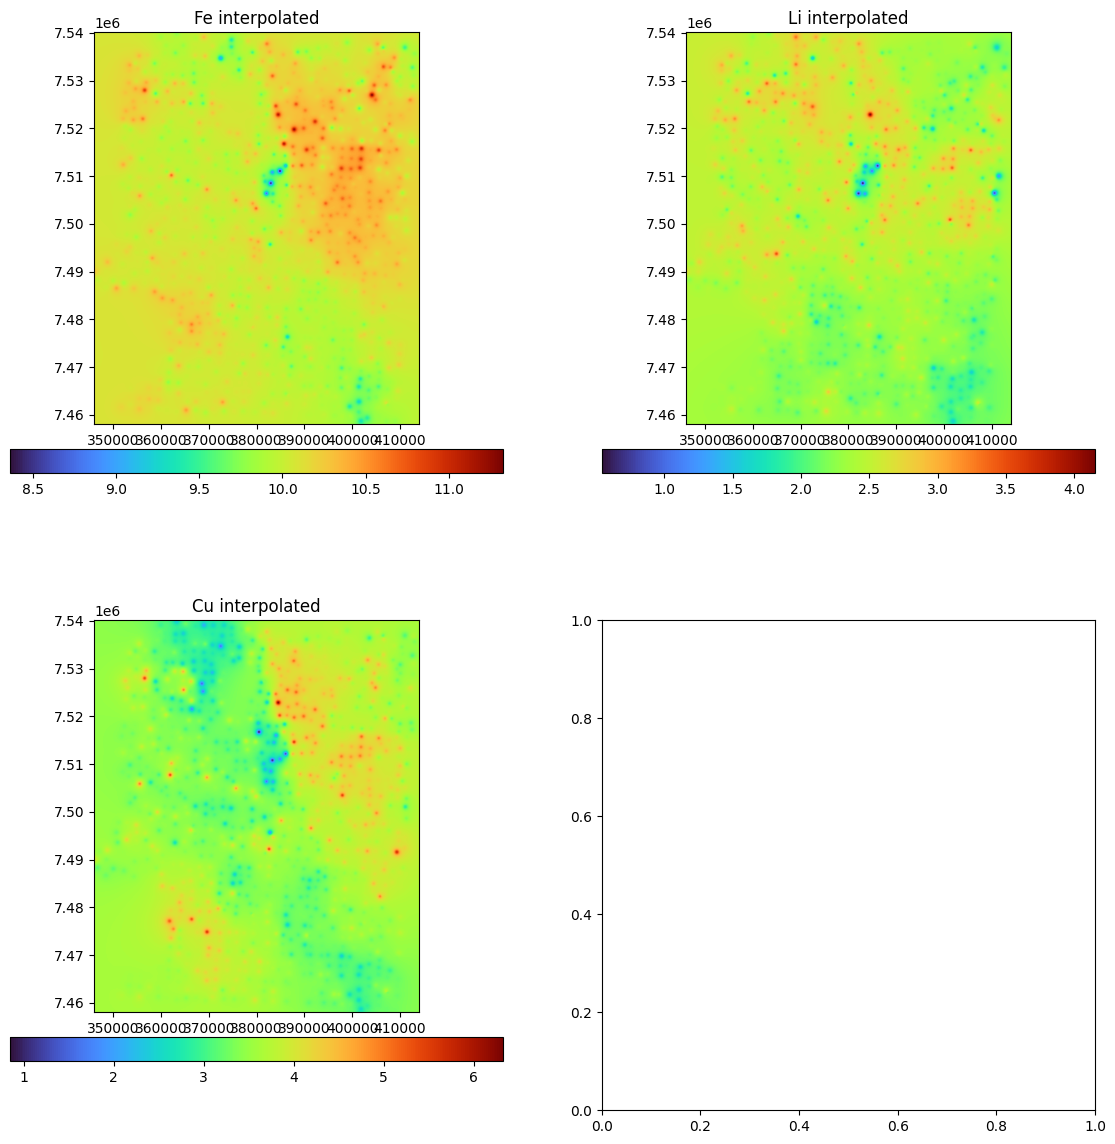

In [13]:
# Visualize interpolated element concentrations
fig, axs = plt.subplots(2, 2, figsize = (14, 14))
cmap = plt.get_cmap('turbo')

axs[0, 0].set_title("Fe interpolated")
clrbar = axs[0, 0].imshow(fe_interpolated, cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(fe_interpolated, ax = axs[0, 0], transform = raster_profile["transform"], cmap=cmap)

axs[0, 1].set_title("Li interpolated")
clrbar = axs[0, 1].imshow(li_interpolated, cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(li_interpolated, ax = axs[0, 1], transform = raster_profile["transform"], cmap=cmap)

axs[1, 0].set_title("Cu interpolated")
clrbar = axs[1, 0].imshow(cu_interpolated, cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(cu_interpolated, ax = axs[1, 0], transform = raster_profile["transform"], cmap=cmap)

#### Preprocess geological data

Compute distances to structures.

In [14]:
structures = gpd.read_file(structures_fp)

In [15]:
distances_to_stuctures = distance_computation(geodataframe=structures, raster_profile=raster_profile)

<Axes: title={'center': 'Distances to structures'}>

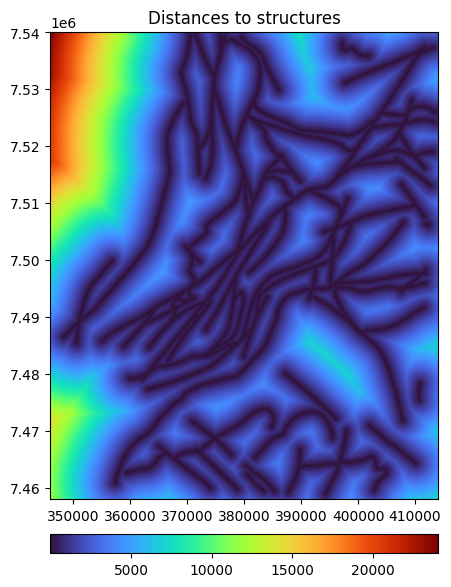

In [16]:
# Visualize distances to structures
fig, ax = plt.subplots(figsize=(5, 9))
cmap = plt.get_cmap('turbo')

ax.set_title("Distances to structures")
clrbar = ax.imshow(distances_to_stuctures, cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(distances_to_stuctures, ax = ax, transform = raster_profile["transform"], cmap=cmap)

#### Preprocess geophysical data

Unify all geophysical rasters and prepare an anomaly raster from one of them.

In [ ]:
# First, open all geophysical data rasters and unify them. While the raster datasets are open,
# we can calculate and collect descriptive statistics for each of them
with \
    MemoryFile() as memfile, \
    rasterio.open(AEM_inphase_fp) as AEM_inphase, \
    rasterio.open(AEM_quad_fp) as AEM_quad, \
    rasterio.open(AEM_ratio_fp) as AEM_ratio, \
    rasterio.open(Magn_AS_fp) as Magn_AS:
        unified_rasters = unify_raster_grids(AEM_inphase, [AEM_quad, AEM_ratio, Magn_AS])
        stats = [
                descriptive_statistics_raster(AEM_inphase),
                descriptive_statistics_raster(AEM_quad),
                descriptive_statistics_raster(AEM_ratio),
                descriptive_statistics_raster(Magn_AS)
        ]

AEM_inphase_data, _ = unified_rasters[0]
AEM_quad_data, _ = unified_rasters[1]
AEM_ratio_data, _ = unified_rasters[2]
Magn_AS_data, _ = unified_rasters[3]

In [18]:
# Statistics for Magnetic raster, which we intend to compute distance to anomalies for
stats[3]

{'min': 0.003132963,
 'max': 164.67801,
 'mean': 2.1845575244451223,
 '25%': 0.57473993,
 '50%': 1.1546912,
 '75%': 2.5222025,
 'standard_deviation': 3.0649950135946704,
 'relative_standard_deviation': 1.4030278348349647,
 'skew': 5.535799740817698}

In [19]:
# Produce anomaly layer from one the rasters

# Here, 100 is crudely approximated as a potentially interesting threhsold value for anomalies based on the statistics above:
# Mean of the data is only as little as 2.18, but max is 164, indicating there are is a couple of very high pixel cells,
# i.e. anomalies
magnetic_anomaly_raster, _ = distance_to_anomaly(raster_profile, Magn_AS_data[0], 100, "higher")

In [20]:
# To futher process the anomaly layer in preparation for modeling, a maximum interesting distance can be set and
# the data values inverted and scaled to range [0, 1]
magnetic_anomaly_raster_capped = magnetic_anomaly_raster.copy()
magnetic_anomaly_raster_capped[magnetic_anomaly_raster_capped > 20000] = 20000

magnetic_anomaly_raster_scaled = _min_max_scaling(magnetic_anomaly_raster_capped, (1, 0))

<Axes: title={'center': 'Distances to magnetic anomalies scaled'}>

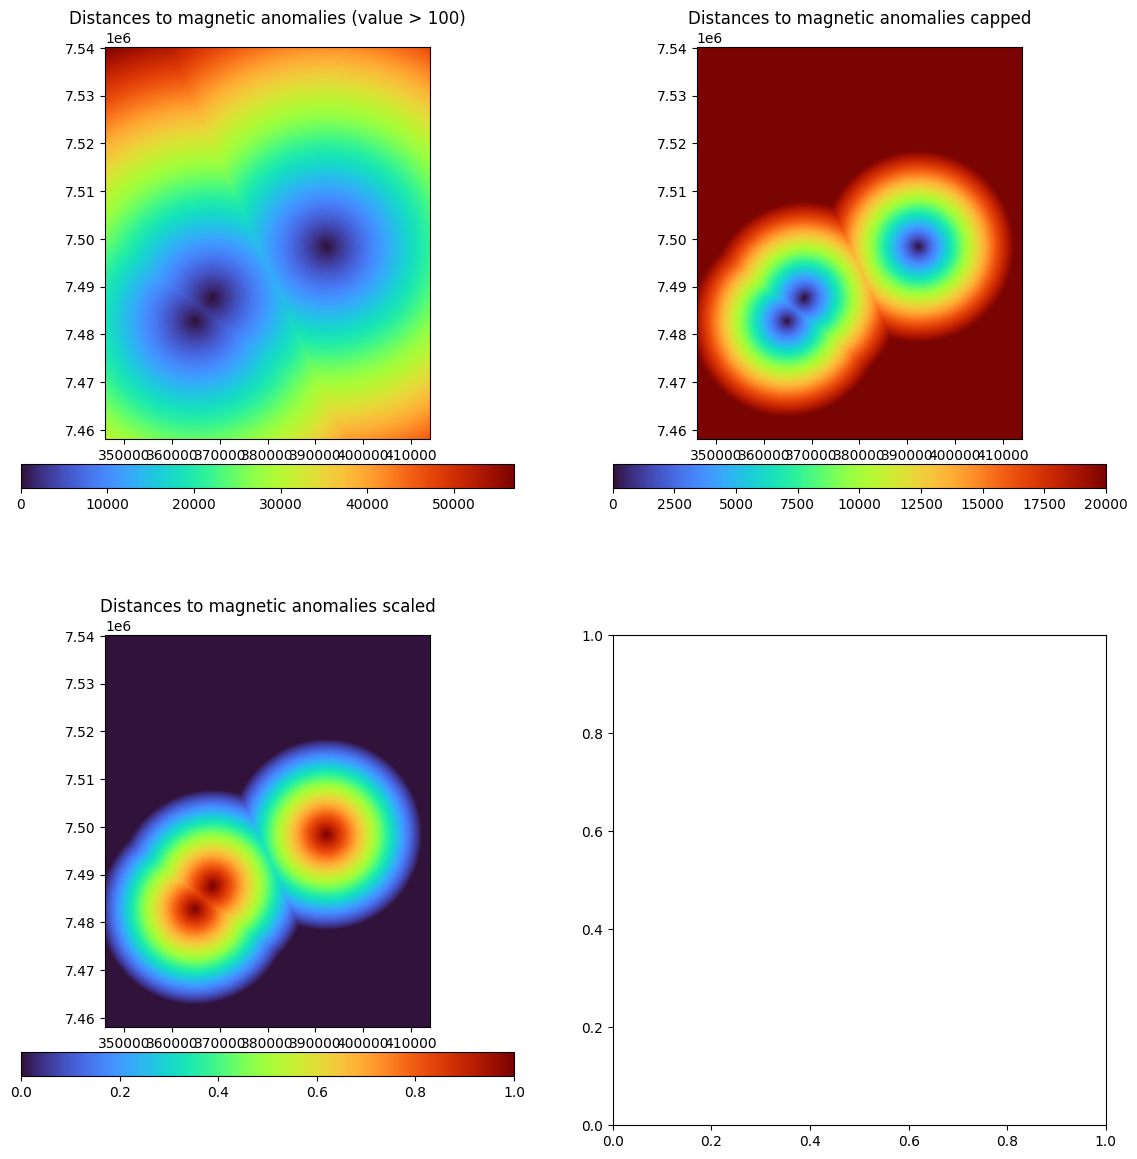

In [21]:
# Visualize anomaly raster at different stages
fig, axs = plt.subplots(2, 2, figsize = (14, 14))
cmap = plt.get_cmap('turbo')

axs[0, 0].set_title("Distances to magnetic anomalies (value > 100)")
clrbar = axs[0, 0].imshow(magnetic_anomaly_raster, cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(magnetic_anomaly_raster, ax = axs[0, 0], transform = raster_profile["transform"], cmap=cmap)

axs[0, 1].set_title("Distances to magnetic anomalies capped")
clrbar = axs[0, 1].imshow(magnetic_anomaly_raster_capped, cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(magnetic_anomaly_raster_capped, ax = axs[0, 1], transform = raster_profile["transform"], cmap=cmap)

axs[1, 0].set_title("Distances to magnetic anomalies scaled")
clrbar = axs[1, 0].imshow(magnetic_anomaly_raster_scaled, cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(magnetic_anomaly_raster_scaled, ax = axs[1, 0], transform = raster_profile["transform"], cmap=cmap)

## 3. Explore data

#### Explore geochemical data

Some plot types to visualize vector data are shown.

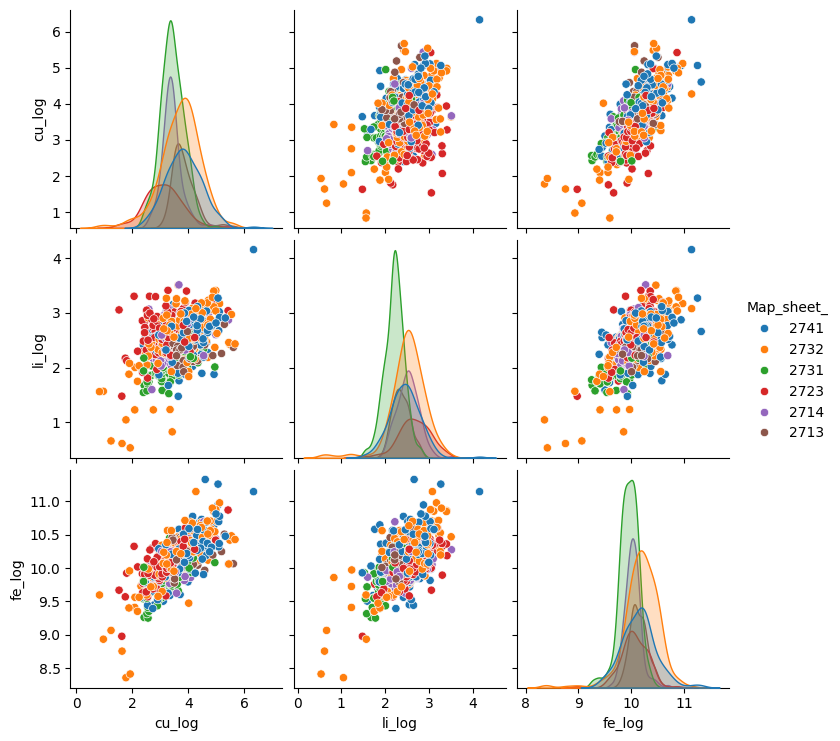

In [39]:
# Subset data for plotting
till_geochem_for_pairplot = till_geochem[["cu_log", "li_log", "fe_log", "Map_sheet_"]]

# Plot pairplot of selected log transformed concentrations
pairplot_grid = pairplot(till_geochem_for_pairplot, hue="Map_sheet_")

Text(0.5, 1.0, 'Geochemical data KDE plot')

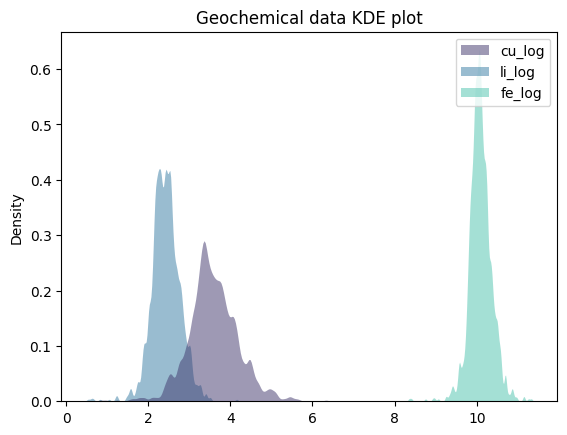

In [40]:
# Subset data for plotting
till_geochem_for_kdeplot = till_geochem[["cu_log", "li_log", "fe_log"]]

# Plot KDE plot of the selected log transformed concentrations
kdeplot(till_geochem_for_kdeplot, bw_adjust=0.4, fill=True, alpha=0.5, linewidth=0, palette="mako").set_title("Geochemical data KDE plot")

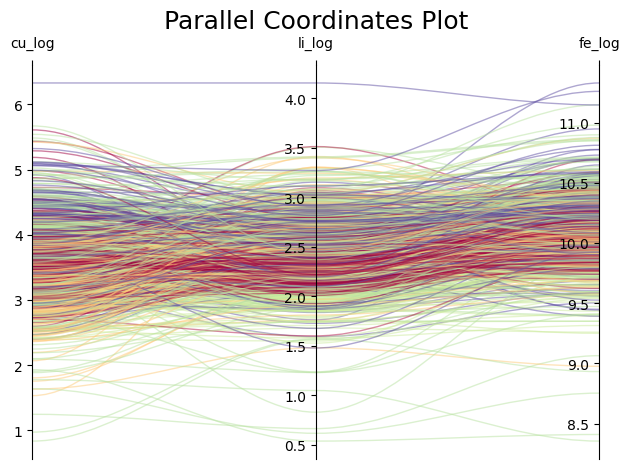

In [42]:
# Plot parallel coordinates for demonstration purposes. In this case, the plot does not reveal any particularly
# interesting patterns from the data
parallel_coordinates_plot = plot_parallel_coordinates(till_geochem_for_pairplot, color_column_name="Map_sheet_")

### 4. Fuzzy logic modeling

This is a very brief demonstration of fuzzy logic modeling. Usually, fuzzy memberships are produced using various
membership functions, but in this all rasters were scaled with the sigmoid transform tool.

In [ ]:
# Transform data before fuzzy overlay
arrays_to_stack = []
for raster_array, meta in unified_rasters:
    raster_array[raster_array == np.nanmin(raster_array)] = np.nan
    out_array = _sigmoid_transform(raster_array, (0, 1), 1, True)
    arrays_to_stack.append(out_array[0])

transformed_arrays_for_fuzzy_overlay = np.stack(arrays_to_stack)

In [42]:
# Compute gamma overlay
overlay_result = gamma_overlay(transformed_arrays_for_fuzzy_overlay, 0.5)

<Axes: title={'center': 'Gamma overlay result'}>

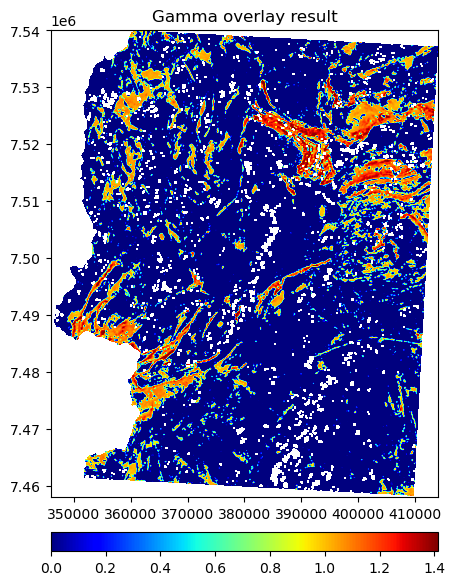

In [43]:
# Plot gamma ovelay result
fig, ax = plt.subplots(1, 1, figsize = (5, 9))

ax.set_title("Gamma overlay result")
clrbar = plt.imshow(overlay_result, cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(overlay_result, ax = ax, transform = raster_profile["transform"], cmap=cmap)

### 5. Weights of evidence modeling
Data for this section can be downloaded from link to data: https://nextcloud.gtk.fi/index.php/s/yqGrRW7sREeoArc.

Please modify the paths accordingly in the corresponding cells of this section

In [16]:
# Calculate weights

with rasterio.open("../tests/data/local/workflow_demo/Discretized_data/Rcls_Dist_Strucs.tif") as distances_structures, \
     rasterio.open("../tests/data/local/workflow_demo/Discretized_data/Rcls_EM_Ratio.tif") as em_ratios, \
     rasterio.open("../tests/data/local/workflow_demo/Discretized_data/Rcls_Mag_Anom.tif") as mag_anom, \
     rasterio.open("../tests/data/local/workflow_demo/Discretized_data/Rcls_Mag_As.tif") as mag_as, \
     rasterio.open("../tests/data/local/workflow_demo/Discretized_data/Rcls_Rd_K.tif") as rad_k:
     deposits = gpd.read_file("../tests/data/local/workflow_demo/Discretized_data/IOCG_Deps_Prosp_Occs.shp")
     
     weights_strucs, arrays_strucs, out_meta, deposit_pixels, evidence_pixels = weights_of_evidence_calculate_weights(
          evidential_raster=distances_structures,
          deposits=deposits, 
          weights_type='ascending',
          studentized_contrast_threshold=2
     )

     weights_aem_ratio, arrays_aem_ratio, _, _, _ = weights_of_evidence_calculate_weights(
          evidential_raster=em_ratios,
          deposits=deposits, 
          weights_type='ascending',
          studentized_contrast_threshold=2
     )    
     
     weights_mag_anom, arrays_mag_anom, _, _, _ = weights_of_evidence_calculate_weights(
          evidential_raster=mag_anom,
          deposits=deposits, 
          weights_type='descending',
          studentized_contrast_threshold=2
     )  
     
     weights_mag_as, arrays_mag_as, _, _, _ = weights_of_evidence_calculate_weights(
          evidential_raster=mag_as,
          deposits=deposits, 
          weights_type='descending',
          studentized_contrast_threshold=2
     )  

     weights_rad_k, arrays_rad_k, _, _, _ = weights_of_evidence_calculate_weights(
        evidential_raster=rad_k,
        deposits=deposits,
        weights_type='descending', 
        studentized_contrast_threshold=2
    )

'\naxs[1, 0].set_title("Generalized weights for Distances to Structures")\nclrbar = axs[1, 0].imshow(arrays_desc["W+"], cmap=cmap)\nplt.colorbar(clrbar, orientation="horizontal", pad = 0.05)\nshow(arrays_desc["W+"], ax = axs[1, 0], transform = out_meta["transform"], cmap=cmap)\n\naxs[1, 1].set_title("Descending weights - S_W+")\nclrbar = axs[1, 1].imshow(arrays_desc["S_W+"], cmap=cmap)\nplt.colorbar(clrbar, orientation="horizontal", pad = 0.05)\nshow(arrays_desc["S_W+"], ax = axs[1, 1], transform = out_meta["transform"], cmap=cmap)\n\naxs[2, 0].set_title("Descending weights - Generalized W+")\nclrbar = axs[2, 0].imshow(arrays_desc["Generalized W+"], cmap=cmap)\nplt.colorbar(clrbar, orientation="horizontal", pad = 0.05)\nshow(arrays_desc["Generalized W+"], ax = axs[2, 0], transform = out_meta["transform"], cmap=cmap)\n\naxs[2, 1].set_title("Descending weights - Generalized S_W+")\nclrbar = axs[2, 1].imshow(arrays_desc["Generalized S_W+"], cmap=cmap)\nplt.colorbar(clrbar, orientation="ho

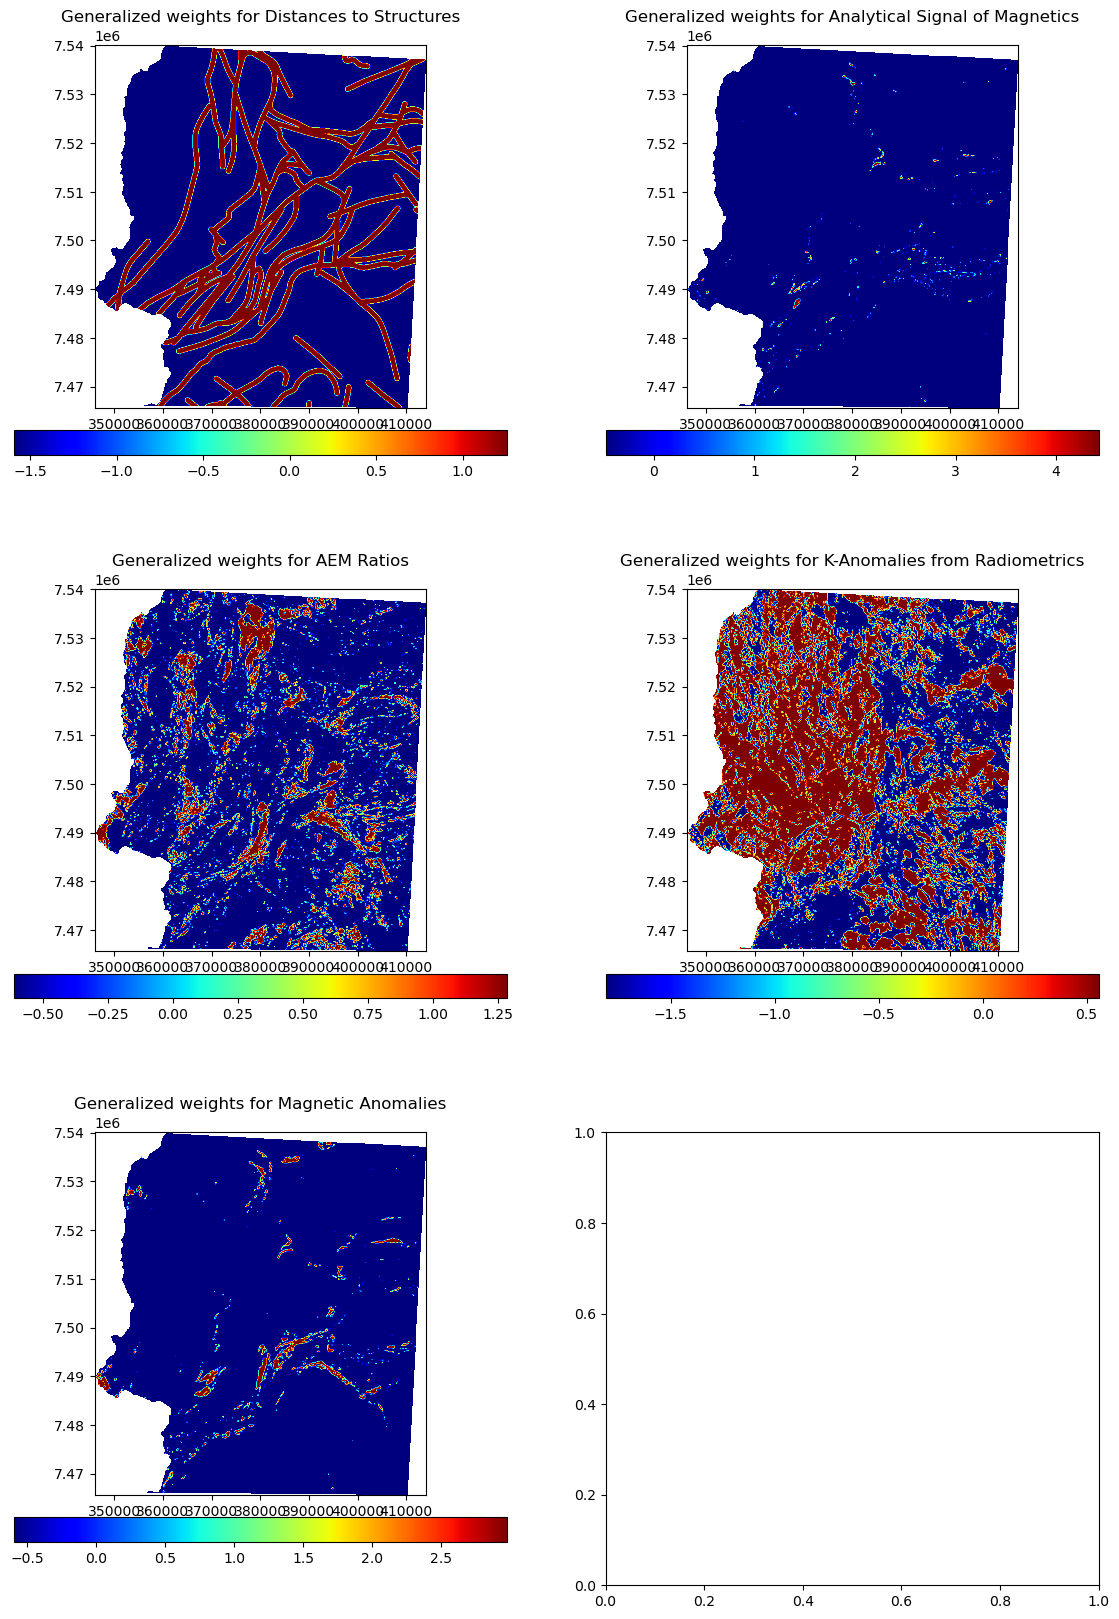

In [30]:
# Valize generalized weights arrays
fig, axs = plt.subplots(3, 2, figsize = (14, 20))

axs[0, 0].set_title("Generalized weights for Distances to Structures")
clrbar = axs[0, 0].imshow(arrays_strucs["Generalized W+"], cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(arrays_strucs["Generalized W+"], ax = axs[0, 0], transform = out_meta["transform"], cmap=cmap)

axs[1, 0].set_title("Generalized weights for AEM Ratios")
clrbar = axs[1, 0].imshow(arrays_aem_ratio["Generalized W+"], cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(arrays_aem_ratio["Generalized W+"], ax = axs[1, 0], transform = out_meta["transform"], cmap=cmap)

axs[2, 0].set_title("Generalized weights for Magnetic Anomalies")
clrbar = axs[2, 0].imshow(arrays_mag_anom["Generalized W+"], cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(arrays_mag_anom["Generalized W+"], ax = axs[2, 0], transform = out_meta["transform"], cmap=cmap)

axs[0, 1].set_title("Generalized weights for Analytical Signal of Magnetics")
clrbar = axs[0, 1].imshow(arrays_mag_as["Generalized W+"], cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(arrays_mag_as["Generalized W+"], ax = axs[0, 1], transform = out_meta["transform"], cmap=cmap)

axs[1, 1].set_title("Generalized weights for K-Anomalies from Radiometrics")
clrbar = axs[1, 1].imshow(arrays_rad_k["Generalized W+"], cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(arrays_rad_k["Generalized W+"], ax = axs[1, 1], transform = out_meta["transform"], cmap=cmap)

In [31]:
# Calculate posterior probabilities / responses
posterior_array, posterior_array_std, posterior_confidence = weights_of_evidence_calculate_responses([arrays_strucs, arrays_aem_ratio, arrays_mag_anom, arrays_mag_as, arrays_rad_k], deposit_pixels, evidence_pixels)

<Axes: title={'center': 'Posterior confidence'}>

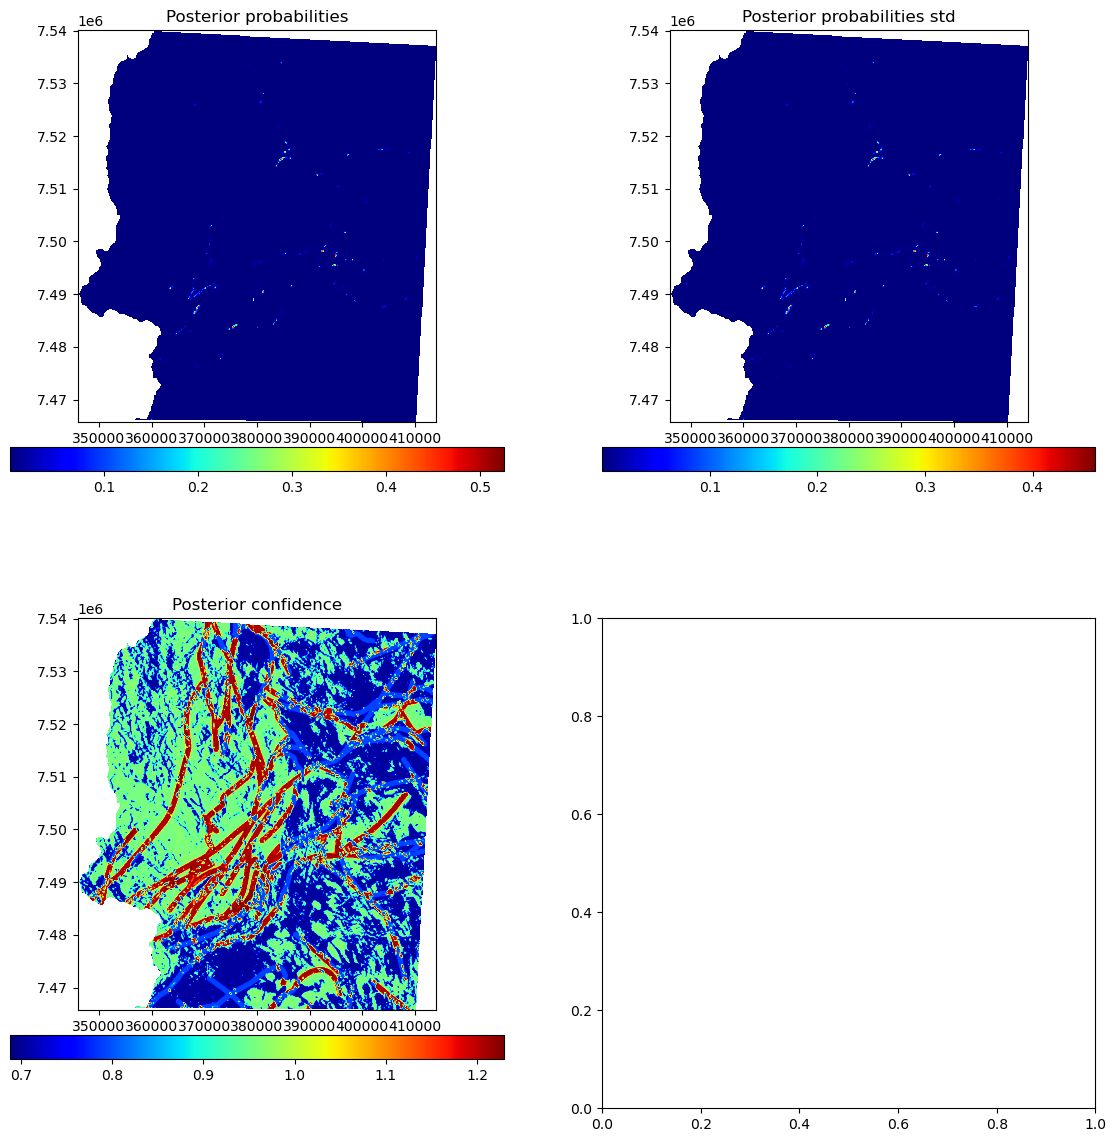

In [32]:
# Plot posterior probabilities weights
cmap = plt.get_cmap('jet')
fig, axs = plt.subplots(2, 2, figsize = (14, 14))

axs[0, 0].set_title("Posterior probabilities")
clrbar = axs[0, 0].imshow(posterior_array, cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(posterior_array, ax = axs[0, 0], transform = out_meta["transform"], cmap=cmap)

axs[0, 1].set_title("Posterior probabilities std")
clrbar = axs[0, 1].imshow(posterior_array_std, cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(posterior_array_std, ax = axs[0, 1], transform = out_meta["transform"], cmap=cmap)

axs[1, 0].set_title("Posterior confidence")
clrbar = axs[1, 0].imshow(posterior_confidence, cmap=cmap)
plt.colorbar(clrbar, orientation="horizontal", pad = 0.05)
show(posterior_confidence, ax = axs[1, 0], transform = out_meta["transform"], cmap=cmap)

### 6. Weights of Evidence Results Evaluation

In [33]:
prospectivity_raster = rasterio.open("../tests/data/local/workflow_demo/Discretized_data/Rescale_W_pprb1.tif")
deposits = gpd.read_file("../tests/data/local/workflow_demo/Discretized_data/IOCG_Deps_Prosp_Occs.shp")

<Axes: >

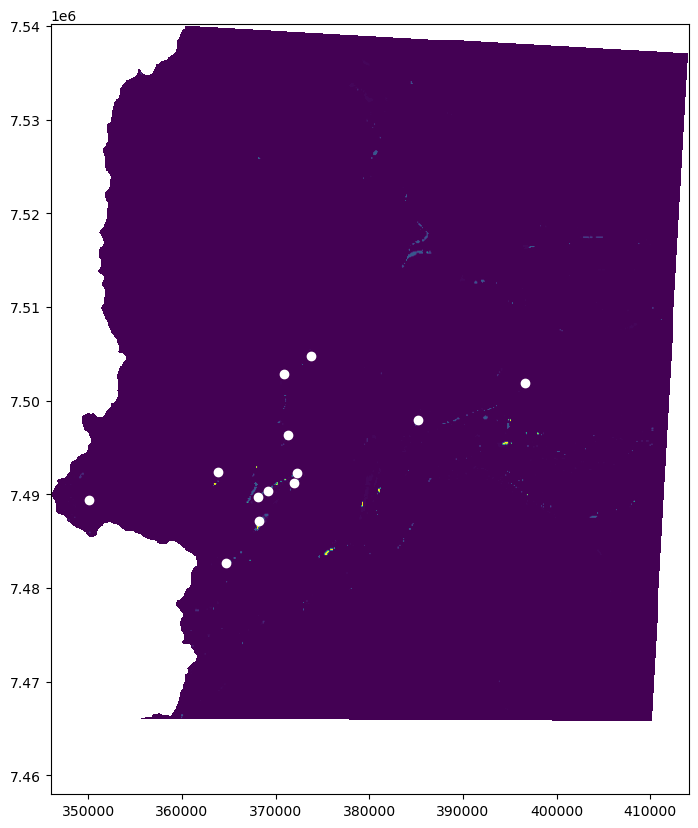

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
rasterio.plot.show(prospectivity_raster, ax=ax)
deposits.plot(ax=ax, facecolor='w', edgecolor='w')

In [35]:
metrics = calculate_base_metrics(raster=prospectivity_raster, deposits=deposits)
metrics

,true_positive_rate_values,proportion_of_area_values,threshold_values
0,0.000000,0.000163,1.000000e+00
1,0.153846,0.000443,3.024189e-01
2,0.230769,0.001125,2.756724e-01
3,0.307692,0.001590,4.810836e-02
4,0.384615,0.003666,2.851541e-03
5,0.461538,0.004707,2.725697e-03
6,0.846154,0.018130,5.111912e-04
7,0.923077,0.070688,7.635408e-05
8,1.000000,0.121263,2.893874e-05
9,1.000000,1.000000,-3.402823e+38


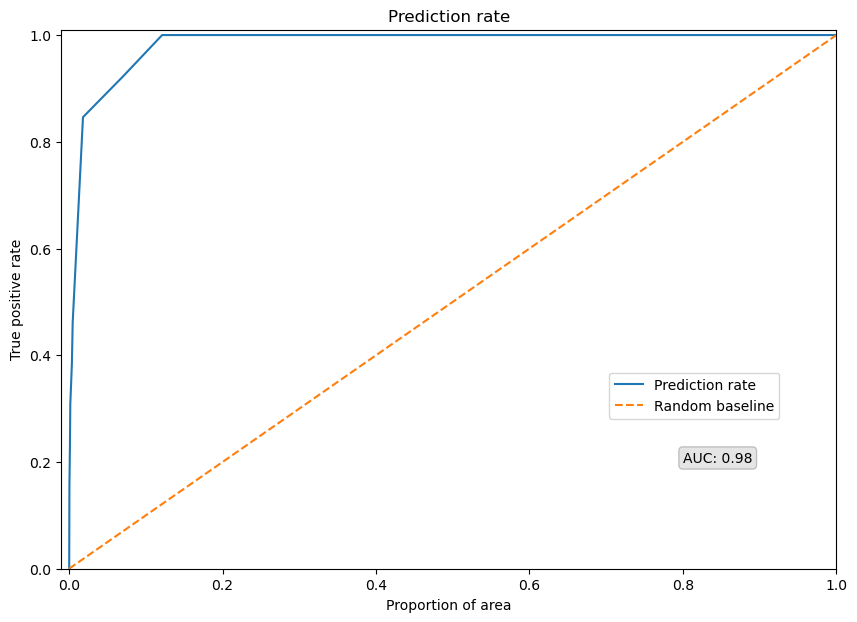

In [36]:
p = plot_rate_curve(metrics["proportion_of_area_values"], metrics["true_positive_rate_values"], "prediction_rate")